# Projet Radiography Covid19

## 2 - Pre processing

Les étapes du pré-processing sont : 
- normalisation de l'intensité des pixels
- vérification de la superposition des masques
- suppression d'artefacts
- équilibre entre les jeux de données
- besoin d'augmentation des données

### Imports et gestion des chemins

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

In [3]:
cwd_dir = os.getcwd()
print("working directory (doit être notebooks) : \n", cwd_dir, "\n")

data_path = os.path.join("..", "data", "processed")
folder_content_list = os.listdir(
    data_path)
print("contenu du dossier data/processed : \n", folder_content_list)


working directory (doit être notebooks) : 
 c:\Users\Florent\Documents\data_science\MAR24_BDS_Radios_Pulmonaire\notebooks 

contenu du dossier data/processed : 
 ['.gitkeep', 'average_images', 'Lung Segmentation Data', 'test_fd_dilatation', 'test_fd_normalisation', 'test_fd_superposition']


In [4]:
data_path = os.path.join("..", "data", "processed")
covid_path = os.path.join(data_path, "Lung Segmentation Data", "COVID-19")
noncovid_path = os.path.join(data_path, "Lung Segmentation Data", "Non-COVID")
normal_path = os.path.join(data_path, "Lung Segmentation Data", "Normal")

# dossier contenant les images normalisées (avec la même structure en 3 sous dossiers, créés à la main) :
norm_path = os.path.join(data_path, "test_fd_normalisation")
norm_covid_path = os.path.join(norm_path, "COVID-19")
norm_noncovid_path = os.path.join(norm_path, "Non-COVID")
norm_normal_path = os.path.join(norm_path, "Normal")

# dossier contenant les superpositions images - masque :
superposition_path = os.path.join(data_path, "test_fd_superposition")
superposition_covid_path = os.path.join(superposition_path, "COVID-19")
superposition_noncovid_path = os.path.join(superposition_path, "Non-COVID")
superposition_normal_path = os.path.join(superposition_path, "Normal")

# dossier contenant les superpositions images - masques avec dilatation :
dilatation_path = os.path.join(data_path, "test_fd_dilatation")
dilatation_covid_path = os.path.join(dilatation_path, "COVID-19")
dilatation_noncovid_path = os.path.join(dilatation_path, "Non-COVID")
dilatation_normal_path = os.path.join(dilatation_path, "Normal")


dict_data_path = {
    'COVID' : covid_path,
    'Non-COVID' : noncovid_path,
    'Normal' : normal_path,
}

dict_norm_path = {
    'COVID' : norm_covid_path,
    'Non-COVID' : norm_noncovid_path,
    'Normal' : norm_normal_path,
}

# données processed - normalisées
dict_data_norm_path = {
    'COVID' : [covid_path, norm_covid_path],
    'Non-COVID' : [noncovid_path, norm_noncovid_path],
    'Normal' : [normal_path, norm_normal_path],
}

# données normalisées - superposées - processed
dict_norm_sup_data_path = {
    'COVID' : [norm_covid_path, superposition_covid_path, covid_path],
    'Non-COVID' : [norm_noncovid_path, superposition_noncovid_path, noncovid_path],
    'Normal' : [norm_normal_path, superposition_normal_path, normal_path],
}

# données normalisées - dilatation+superposées - processed
dict_norm_dilat_data_path = {
    'COVID' : [norm_covid_path, dilatation_covid_path, covid_path],
    'Non-COVID' : [norm_noncovid_path, dilatation_noncovid_path, noncovid_path],
    'Normal' : [norm_normal_path, dilatation_normal_path, normal_path],
}

### Normalisation 

- Pour chacun des 3 datasets séparément.  
- Normalisation min-max (chaque valeur de pixel sera entre 0 et 1).  
- On normalise chaque image individuellement selon ses propres paramètres min et max plutôt qu'avec les paramètre de sa classe (COVID, Normal , Non COVID), pour ne pas introduire un biais qui ferait apporterait une différence entre les classes par la normalisation propre à chaque classe.

In [4]:
def normalisation_min_max(image_path: str, output_path: str):
    """ Fonction qui normalise l'intensité d'une image .png en niveaux de gris.
    Retourne une nouvelle image normalisée.
    """

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    min_val = np.min(image)
    max_val = np.max(image)
    
    # Normalisation min-max
    normalized_image = (image - min_val) / (max_val - min_val)
    
    # Remise à l'échelle [0, 255]
    normalized_image = (normalized_image * 255).astype(np.uint8)
    
    cv2.imwrite(output_path, normalized_image)


In [5]:
for key, paths in dict_data_norm_path.items():
    print(key)

    source_folder_path  = os.path.join(paths[0], "images")
    normalized_folder_path  = paths[1]
    source_files = os.listdir(source_folder_path) 
    
    for file in source_files:
        source_png_path = os.path.join(source_folder_path, file)
        normalized_png_path = os.path.join(normalized_folder_path, file)

        # normalisation + sauvegarde 
        normalisation_min_max(image_path = source_png_path, output_path = normalized_png_path)



COVID
Non-COVID
Normal


In [6]:
# Verification que toutes les images ont bien été normalisées :

rows_verif_norm = []

for key, paths in dict_data_norm_path.items():

    print(key)

    source_folder_path  = os.path.join(paths[0], "images")
    normalized_folder_path  = paths[1]
    source_files = set(os.listdir(source_folder_path))
    norm_files = set(os.listdir(normalized_folder_path)) 

    source_not_in_norm = source_files - norm_files
    norm_not_in_source = norm_files - source_files

    nb_source_not_in_norm = len(source_not_in_norm)
    nb_norm_not_in_source = len(norm_not_in_source)

    if nb_source_not_in_norm not in locals():
        nb_source_not_in_norm = 0

    if nb_norm_not_in_source not in locals():
        nb_norm_not_in_source = 0

    rows_verif_norm.append({
        "data": key, 
        "Nb fichiers source": len(source_files),
        "Nb fichiers normalisés": len(norm_files),
        "Nb source non retrouvés normalisés": nb_source_not_in_norm, 
        "Nb norm non retrouvés dans source": nb_norm_not_in_source
        })
    
    df_verif_norm = pd.DataFrame(rows_verif_norm)


print("shape df_verif_norm :", df_verif_norm.shape)
df_verif_norm.head(3)

COVID
Non-COVID
Normal
shape df_verif_norm : (3, 5)


,data,Nb fichiers source,Nb fichiers normalisés,Nb source non retrouvés normalisés,Nb norm non retrouvés dans source
0,COVID,11956,11956,0,0
1,Non-COVID,11263,11263,0,0
2,Normal,10701,10701,0,0


### Equilibrage entre les jeux de données

Besoin d'avoir un équilibre parfait ?  

### Vérifications sur les masques

Les masques sont agrandis pour contenir mieux la zone du bord des poumons (qui peut être plus impactée que le poumon dans un COVID).  
Une vérification visuelle va être faite sur un échantillon pour chaque groupe.  


In [7]:
def superposition_image_mask(image, mask, alpha=0.5):
    """ Construit une image avec la superposition d'une image et d'un masque.
    Retourne une image.
    """
    # Resize the mask to match the dimensions of the image (if necessary)
    if image.shape[:2] != mask.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Overlay the mask onto the image
    overlay = cv2.addWeighted(image, 1 - alpha, mask, alpha, 0)
    
    return overlay

In [21]:
def superposition_image_mask_black(image, mask):
    """ Construit une image avec la superposition d'une image et d'un masque, en gardant la partie noire 
    du mask et en affichant l'image sur la partie blanche du mask.
    Retourne une image.
    """
    # Resize the mask to match the dimensions of the image (if necessary)
    if image.shape[:2] != mask.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Perform bitwise AND operation to keep content in white areas of the mask
    masked_content = cv2.bitwise_and(image, image, mask=mask)

    # Create a black image of the same size as the original image
    black_image = np.zeros_like(image)

    # Perform bitwise AND operation to keep black areas of the mask
    black_areas = cv2.bitwise_and(black_image, black_image, mask=mask)

    # Combine the masked content and black areas using bitwise OR operation
    result = cv2.bitwise_or(masked_content, black_areas)
   
    return result

In [16]:
# test sur 20 images au hasard 

for key, paths in dict_norm_sup_data_path.items():
    print(key)

    images_path = paths[0]
    masks_path = os.path.join(paths[2], "lung masks")
    superposition_path = paths[1]

    files = os.listdir(images_path)
    rdm_selected_files = random.sample(files, min(20, len(files)))
   
    for file in rdm_selected_files:
        image_file = os.path.join(images_path, file)
        mask_file = os.path.join(masks_path, file)

        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print("Error: Unable to read image file")
            print(image_file, "\n",  mask_file)
            exit()
        elif mask is None:
            print("Error: Unable to read mask file")
            print(image_file, "\n",  mask_file)
            exit()

        superposition = superposition_image_mask(image, mask, alpha=0.5)

        output_path = os.path.join(superposition_path, file)
        cv2.imwrite(output_path, superposition)


COVID
Non-COVID
Normal


### Dilatation des masques pour englober la périphérie des poumons

Superposition des masques en gardant la partie noire pour masquer l'image, et en faisant apparaître l'image sur la partie blanche, qui correpond aux poumons.  
Test des kernels : carré, nombre de pixels par côté.

In [ ]:
# agrandissements des zones des masques, sans augmenter les dimensions de l'image 

# test des methodes sur qq images 

# quel kernel choisir en taille, en forme
# tester sur qq images
# tester les differentes formes de kernel 

# https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html


In [58]:
def dilatation_masque_carre_superposition(mask, nb_pixels, image, file):    
    """ Applique la fonction superposition_image_mask_black 
    avec un mask qui a subit une dilatation avec un kernel carré.
    Enregistre l'image obtenue.
    Retourne le nom de l'image obtenue et son chemin.
    """
    kernel = np.ones((nb_pixels, nb_pixels), np.uint8)
    dilatation = cv2.dilate(mask, kernel)

    superposition = superposition_image_mask_black(image, dilatation)
    
    file_name = "kernel_carre_" + str(nb_pixels) + file
    output_path = os.path.join(dilatation_path, file_name)
    
    cv2.imwrite(output_path, superposition)
    return file_name, output_path
    

In [76]:
def display_4_masks(png_dict, titre, save_path):
    """ Crée une image avec les 4 images corespondant au test des 4 valeurs de kernels.
    Affiche et enregistre l'image.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Flatten the axes array
    axes = axes.flatten()

    # Load and display each image in a subplot
    for i, (image_file, value) in enumerate(png_dict.items()):
        image_path = os.path.join(value[1], image_file)

        # Load the image
        image = plt.imread(image_path)

        # Display the image as grayscale
        axes[i].imshow(image, cmap='gray')
        
        axes[i].set_title(value[0])
        axes[i].axis('off')

    # Adjust layout and display the figure
    plt.tight_layout()
    fig.suptitle(titre, fontsize=16)
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.5, wspace=0.5)
    
    # plt.show()

    fig.savefig(save_path, format='png')
    # plt.close(fig) 

COVID
Non-COVID
Normal


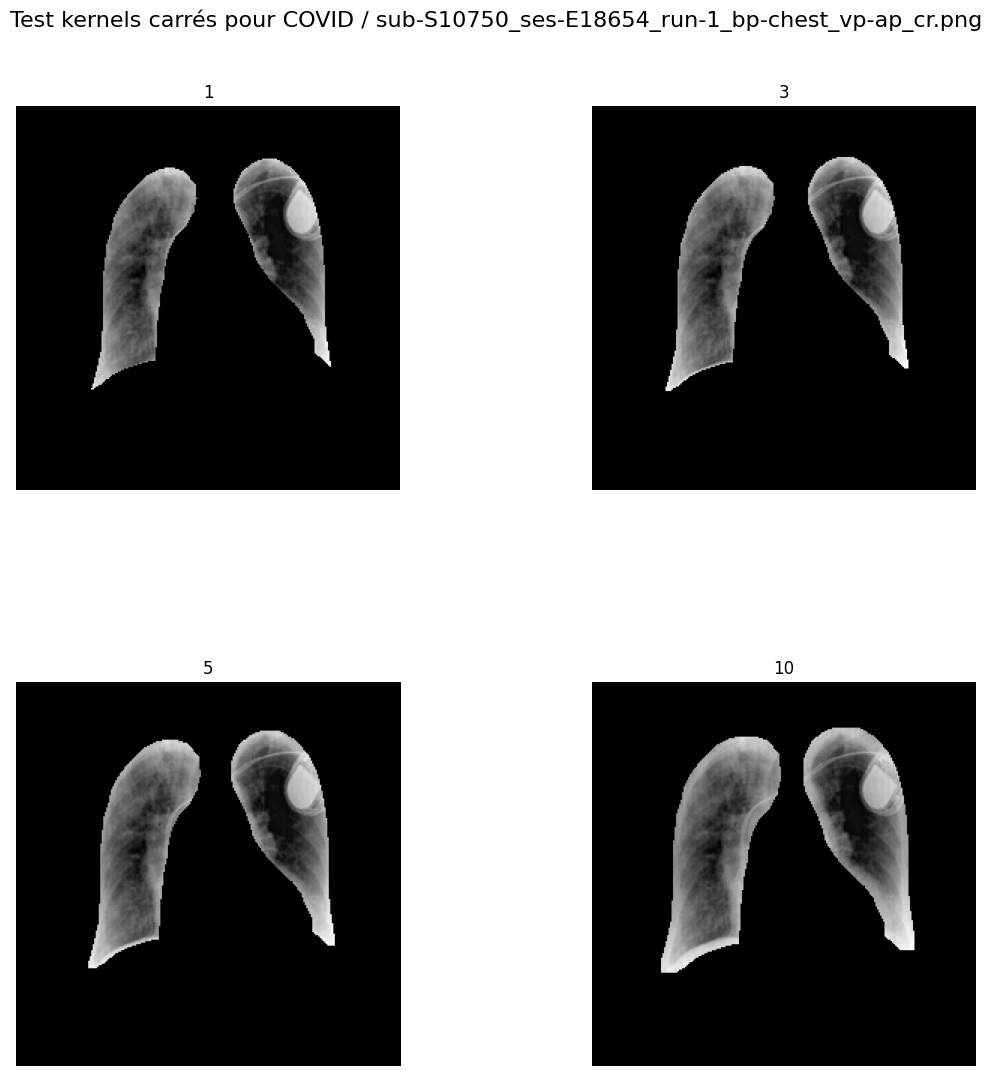

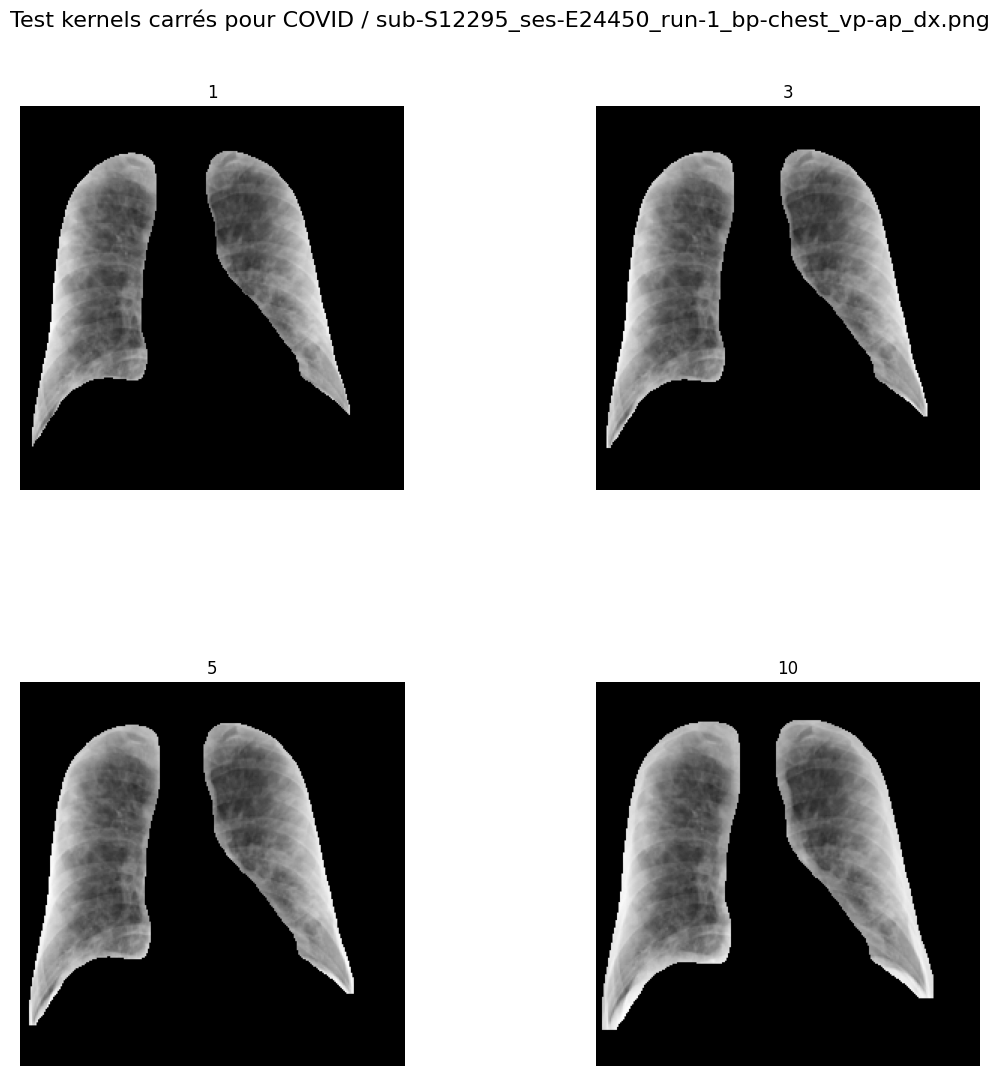

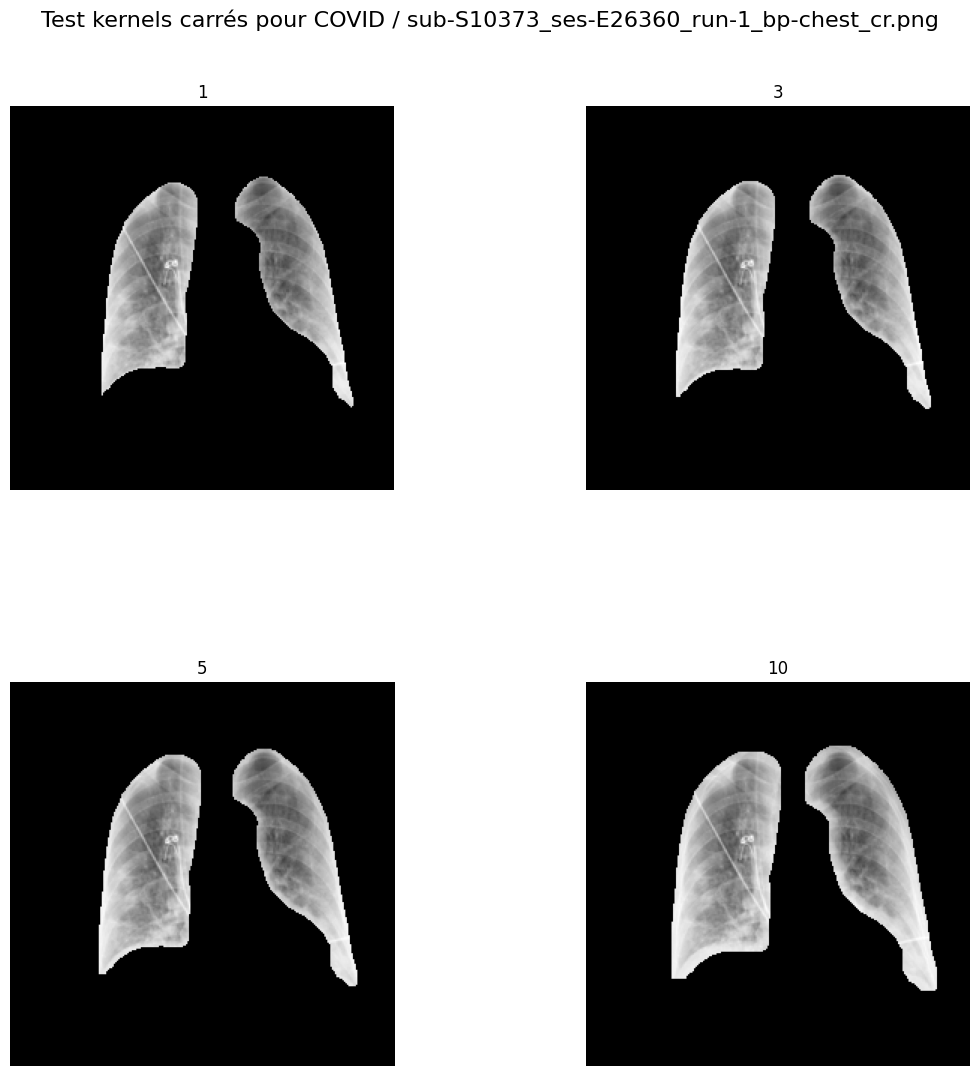

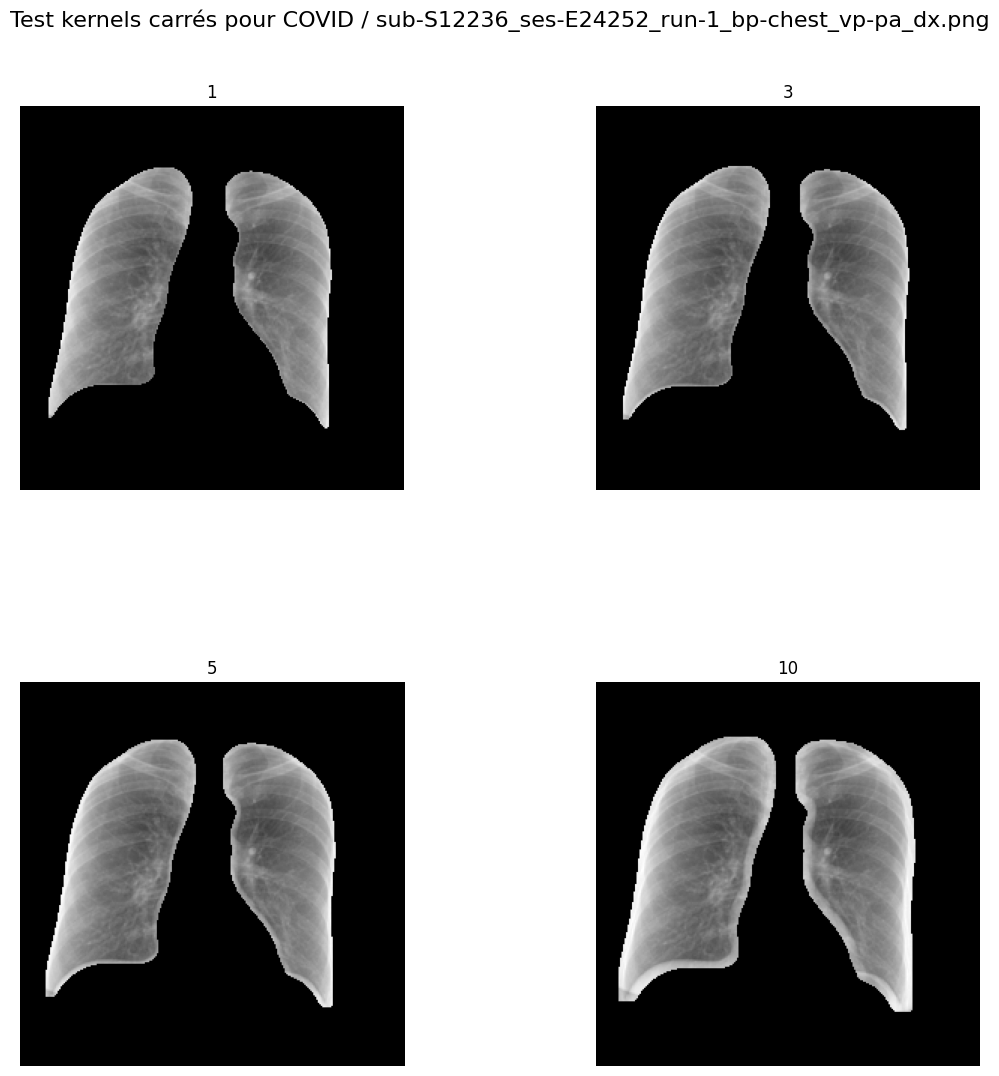

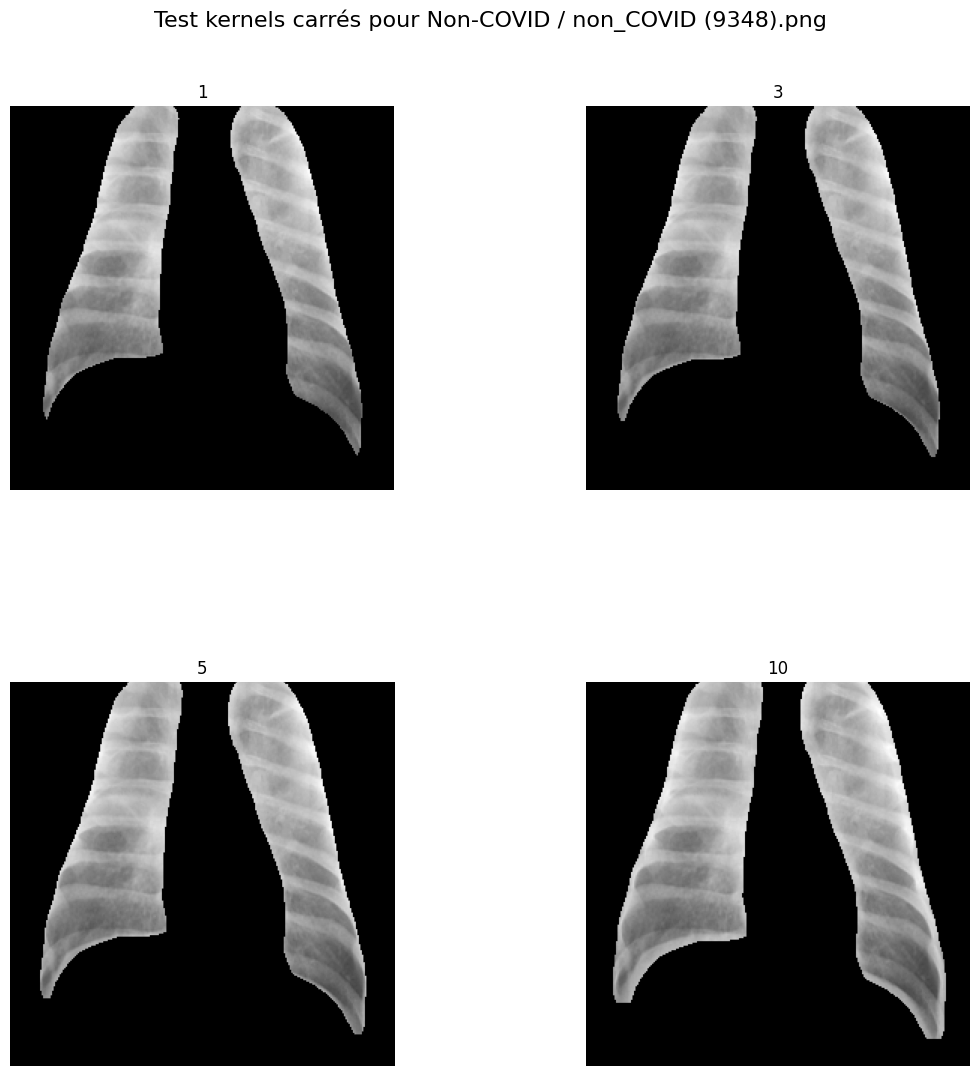

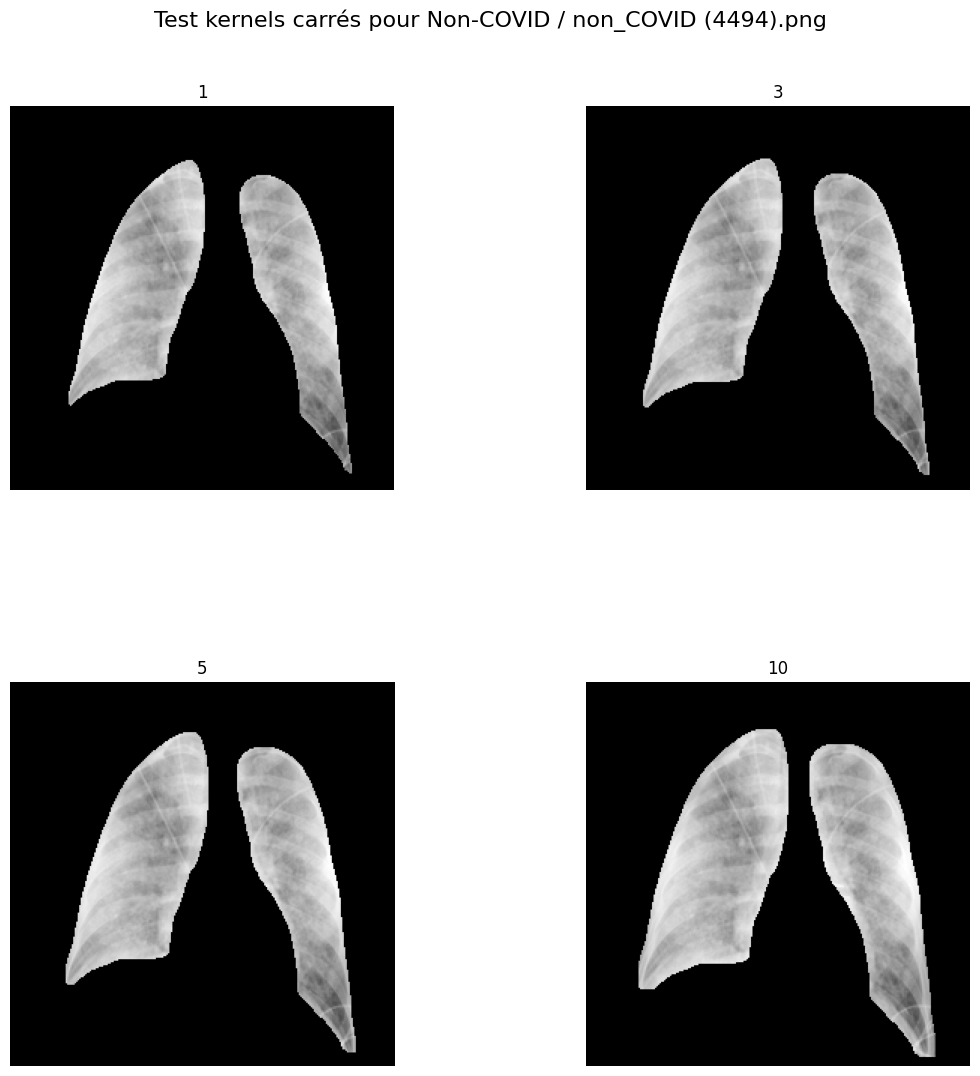

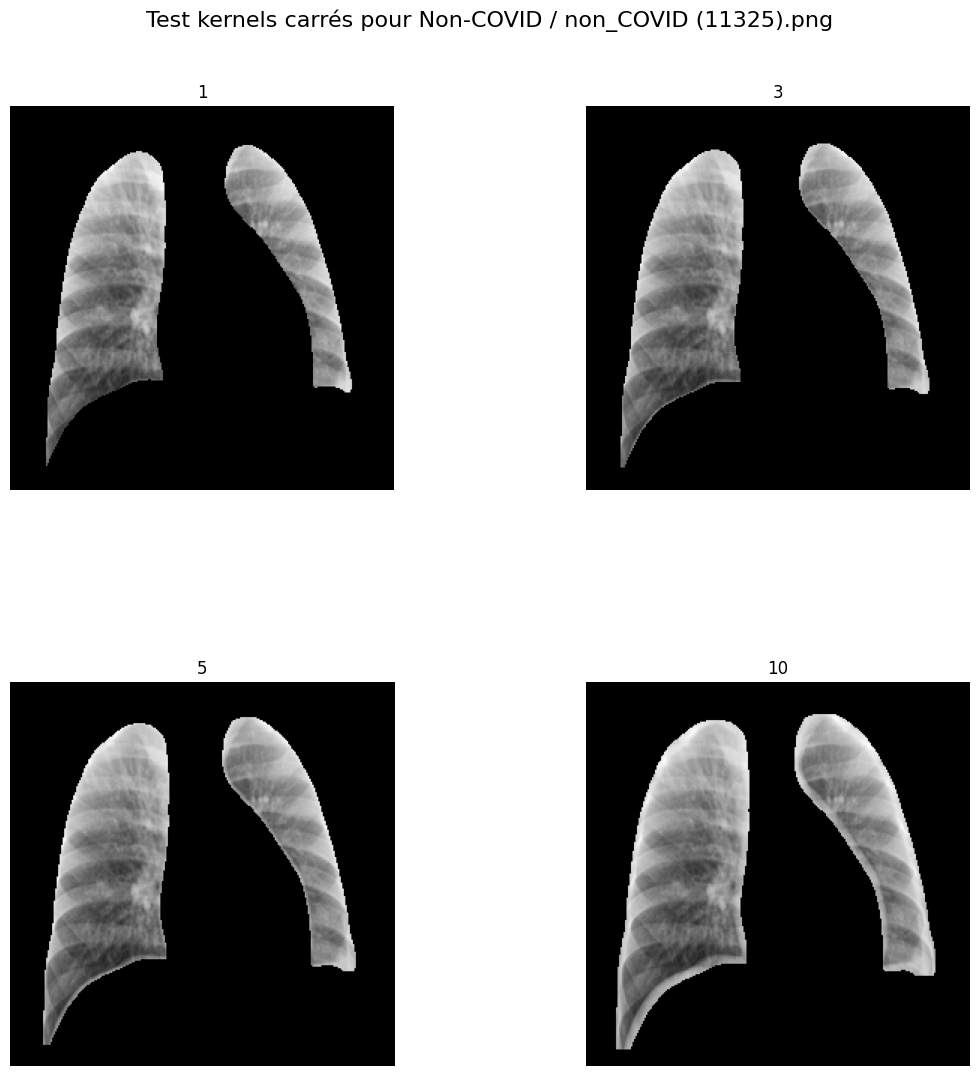

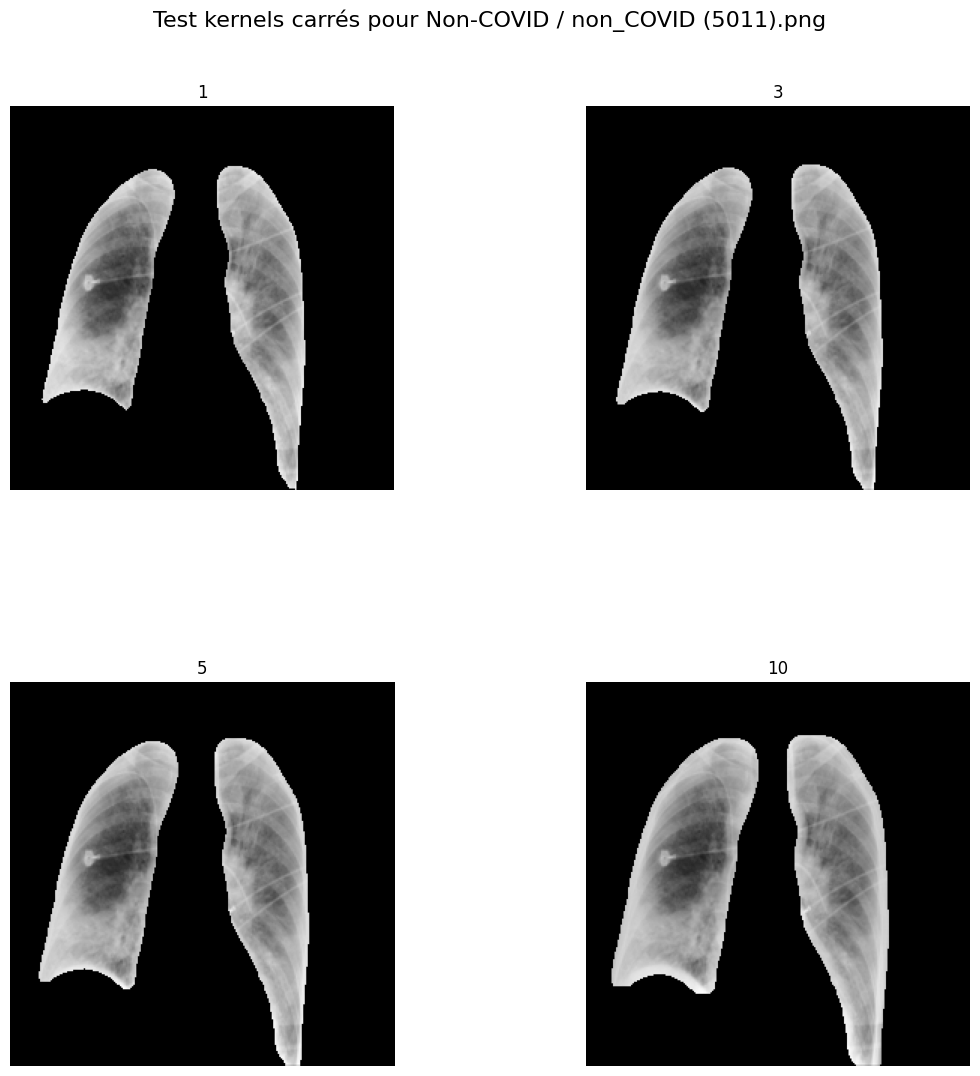

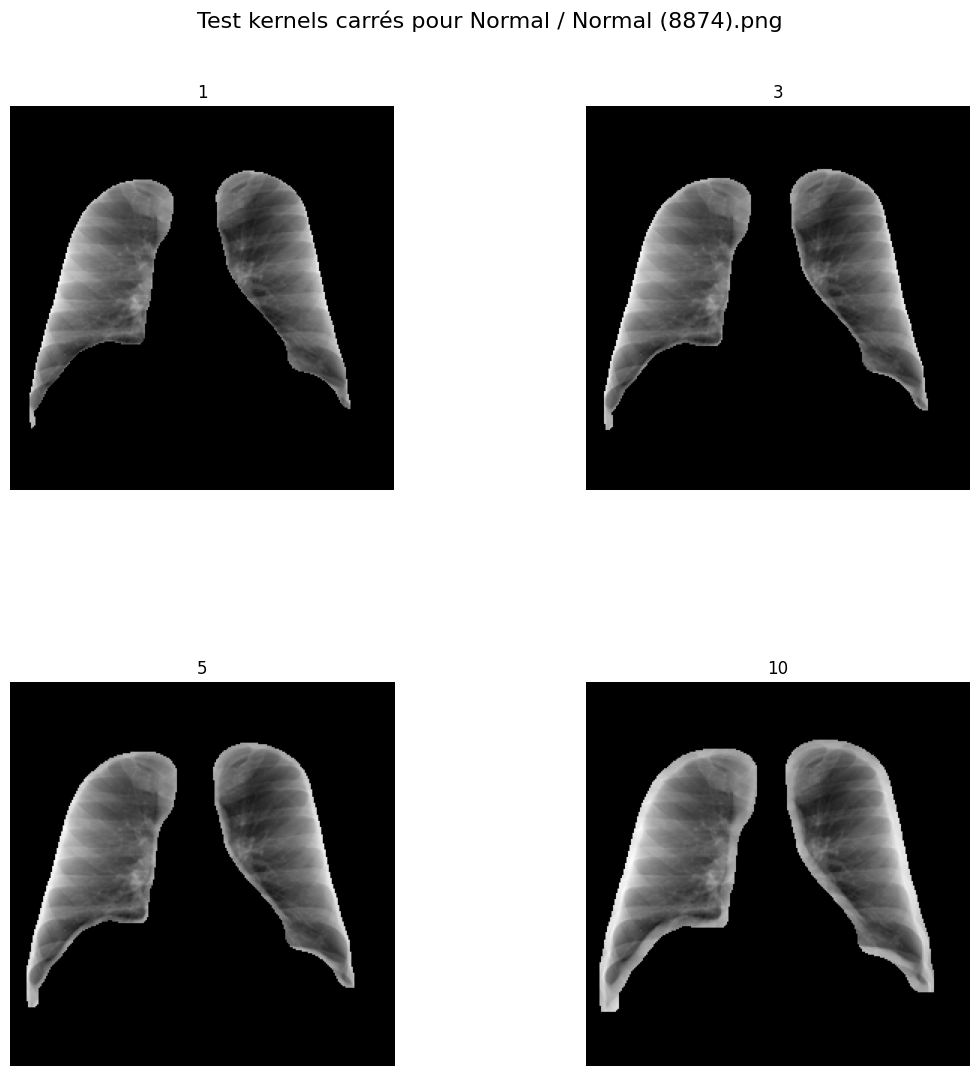

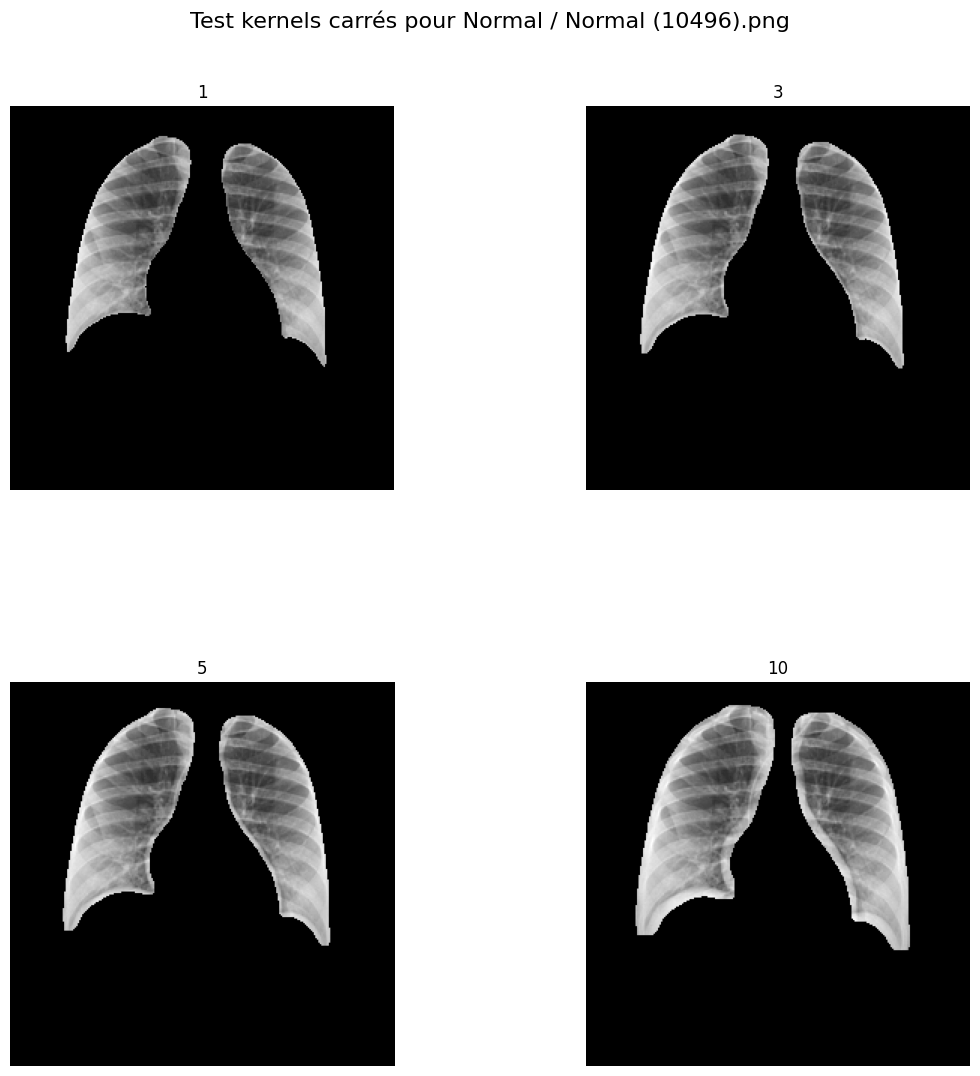

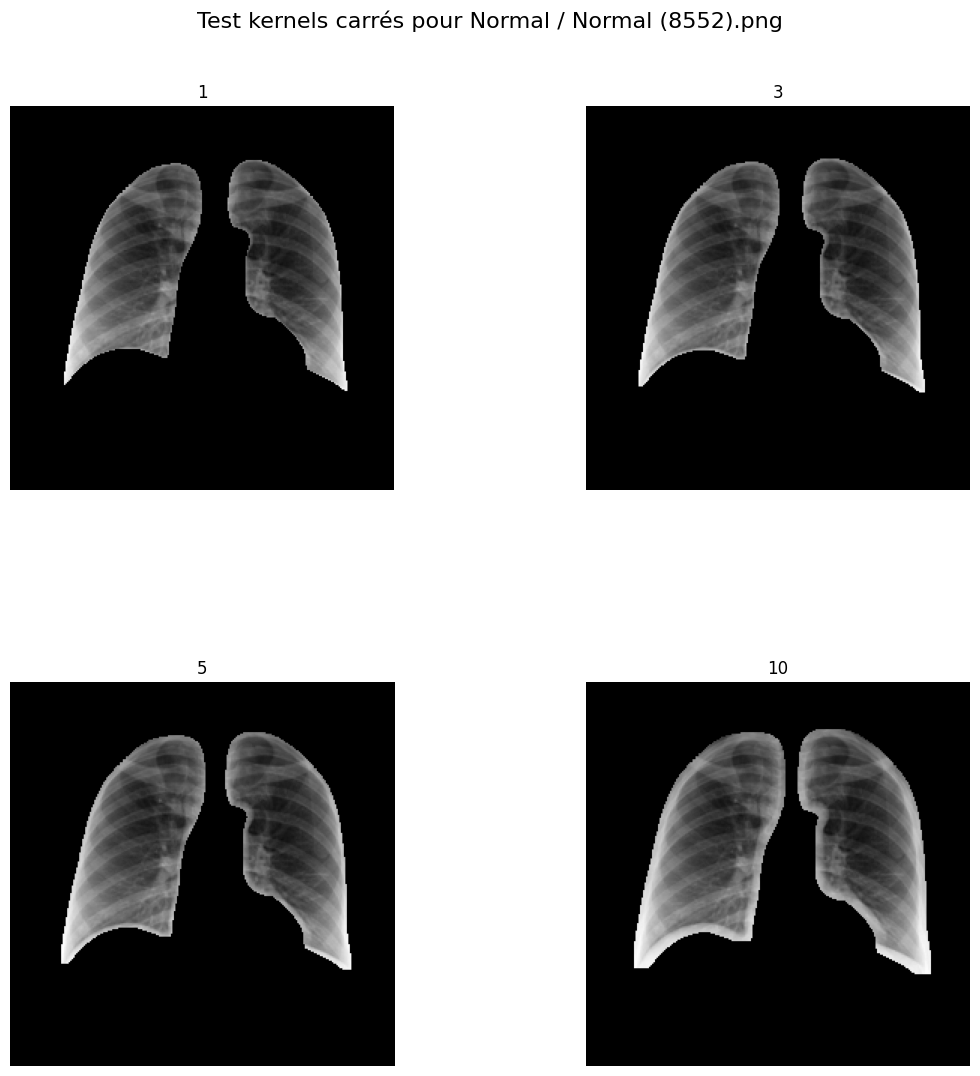

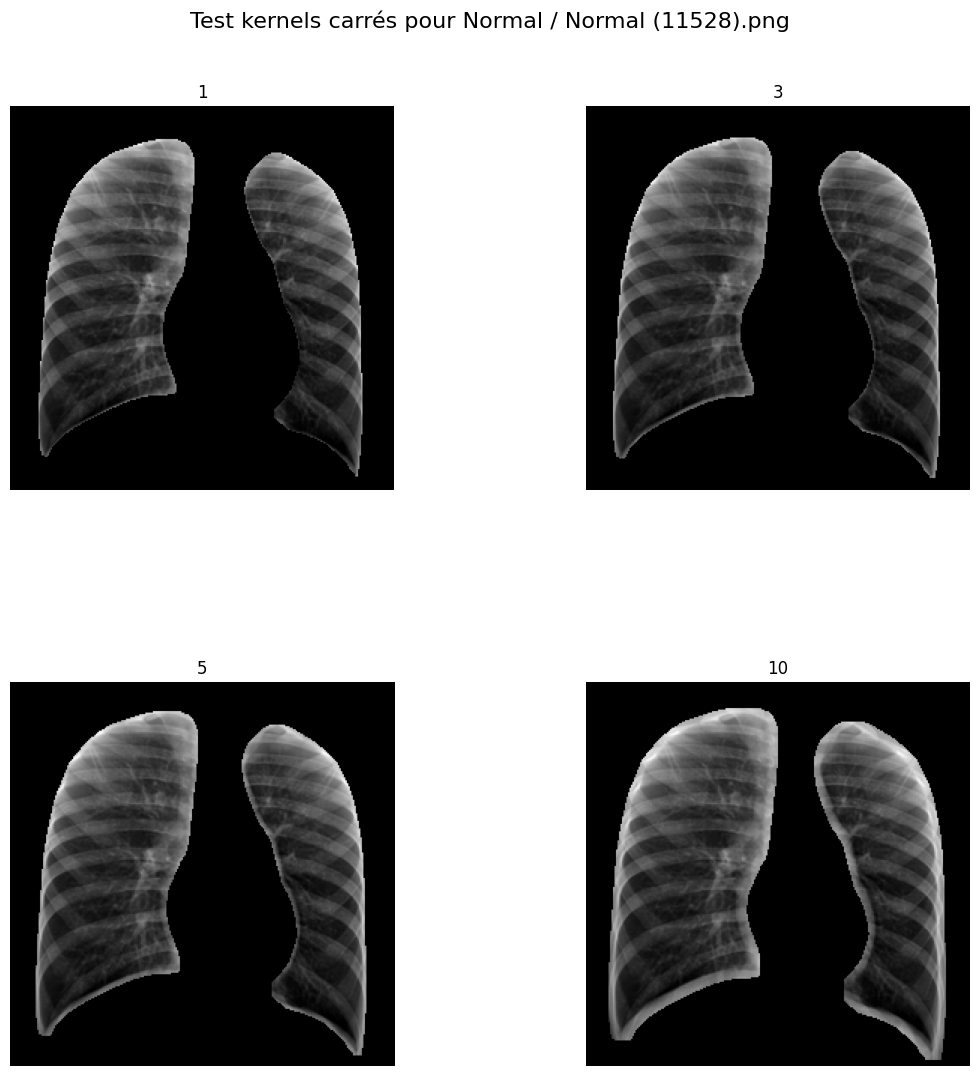

In [77]:
# Test sur 4 images / groupe

for key, paths in dict_norm_dilat_data_path.items():
    print(key)

    images_path = paths[0]
    masks_path = os.path.join(paths[2], "lung masks")
    dilatation_path = paths[1]

    files = os.listdir(images_path)
    rdm_selected_files = random.sample(files, min(4, len(files)))
   
    for file in rdm_selected_files:
        image_file = os.path.join(images_path, file)
        mask_file = os.path.join(masks_path, file)

        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print("Error: Unable to read image file")
            print(image_file, "\n",  mask_file)
            exit()
        elif mask is None:
            print("Error: Unable to read mask file")
            print(image_file, "\n",  mask_file)
            exit()

        dict_kernel_image = {}

        # Test de 4 valeurs de kernel carré
        for nb in [1, 3, 5, 10]:
            file_name, output_path = dilatation_masque_carre_superposition(
                mask=mask, 
                nb_pixels=nb, 
                image=image, 
                file=file)
            
            # creation du dictionnaire pour l'affichage des images pour chacun des 4 kernels
            key_kernel = file_name
            value = [str(nb), dilatation_path]
            dict_kernel_image[key_kernel] = value


        # creation d'une image avec les 4 :
        image4_name = "synthese_" + file
        save_path = os.path.join(dilatation_path, image4_name)
        display_4_masks(dict_kernel_image, f"Test kernels carrés pour {key} / {file}", save_path)
        

In [50]:
for key, value in dict_kernel_image.items():
    print(f"{key}: {value}\n")

kernel_carre_1covid_3429.png: ['kernel_carre_1covid_3429.png', '1', '..\\data\\processed\\test_fd_dilatation\\COVID-19\\kernel_carre_1covid_3429.png']

kernel_carre_3covid_3429.png: ['kernel_carre_3covid_3429.png', '3', '..\\data\\processed\\test_fd_dilatation\\COVID-19\\kernel_carre_3covid_3429.png']

kernel_carre_5covid_3429.png: ['kernel_carre_5covid_3429.png', '5', '..\\data\\processed\\test_fd_dilatation\\COVID-19\\kernel_carre_5covid_3429.png']

kernel_carre_10covid_3429.png: ['kernel_carre_10covid_3429.png', '10', '..\\data\\processed\\test_fd_dilatation\\COVID-19\\kernel_carre_10covid_3429.png']

